### EASILY CUSTOMIZABLE AUTOENCODERS
- 6. feb. 2025
#### Will be moved to **architectures** once finished

In [2]:
# from ...DementiaMRI.Architectures.VAE import VAE
from Data.load import load
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf
from tensorflow.keras import layers, Model, models, Input, activations, regularizers
import tensorflow.keras.backend as K

import time

In [2]:
# WILL MOST LIKELY BE ADDED LATER

# Conv Block
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, ch_in, ch_out, k_size, stride=1, p=1, num_groups=1):
        super(ConvBlock, self).__init__()
        self.conv = models.Sequential([
            layers.Conv3D(ch_out, kernel_size=k_size, strides=stride, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU()
        ])

    def call(self, x):
        return self.conv(x)

# ResNet Block
class ResNetBlock(tf.keras.layers.Layer):
    def __init__(self, ch, k_size, stride=1, p=1, num_groups=1):
        super(ResNetBlock, self).__init__()
        self.conv = models.Sequential([
            layers.Conv3D(ch, kernel_size=k_size, strides=stride, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv3D(ch, kernel_size=k_size, strides=stride, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])

    def call(self, x):
        return self.conv(x) + x # look skip connections, ayooo!

# Up-conv Layer
class UpConv(tf.keras.layers.Layer):
    def __init__(self, ch_in, ch_out, k_size=1, scale=2, align_corners=False):
        super(UpConv, self).__init__()
        self.up = models.Sequential([
            layers.Conv3D(ch_out, kernel_size=k_size),
            layers.UpSampling3D(size=(scale, scale, scale))
        ])

    def call(self, x):
        return self.up(x)

#### LOADING THE DATA

In [3]:
train, test = load(take=50, train_test_split=0.8)
print(train.shape, test.shape)

Loading images:   0%|          | 0/50 [00:00<?, ?it/s]

Loading images: 100%|██████████| 50/50 [00:34<00:00,  1.47it/s]

(40, 80, 96, 80) (10, 80, 96, 80)


In [4]:
class AE(Model):
    def __init__(self, 
                input_shape, 
                latent_dim, 
                encoder_layers, 
                decoder_layers, 
                name="AE", 
                debug=False,
                ):
        
        super(AE, self).__init__(name=name)
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.history = None
        self.debug = debug
        self.compile_model()
    
    def compile_model(self):
        """
        Compile the model by iterating through the provided layers and adding them to the Functional API model.
        """
        shape_changed=False
        if self.input_shape[-1]>3:
            self.input_shape = list(self.input_shape) + [1]
            shape_changed=True
        if len(self.input_shape)>4:
            self.input_shape = self.input_shape[-4:]
            shape_changed=True
        if shape_changed:
            print(f"Interpreted image shape: {tuple(self.input_shape)}", end=" ")


        # 1. Build the encoder model
        input_layer = x = Input(shape=self.input_shape, name="input")  # Input shape from the first encoder layer tuple
        
        # - Add encoder layers
        for layer in self.encoder_layers:
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
            
            print(f"After {x.shape}: {layer}") if self.debug else None


        # - Flatten the latent space (encoding output)
        print(f"Pre-flattened latent shape: {x.shape}")
        pre_flatten_shape = x.shape
        x = layers.Flatten()(x)
        x = layers.Dense(self.latent_dim, activation="relu")(x)  # kernel_regularizer=regularizers.l1(l1_lambda))(x)
        self.encoder = Model(input_layer, x, name="encoder")

        # 2. Build the decoder model
        latent_input = x = layers.Input(shape=x.shape[1:]) # Adjusted latent space shape
        
        # - Reshape back to 3D
        x = layers.Dense(
            pre_flatten_shape[1] * pre_flatten_shape[2] * pre_flatten_shape[3] * pre_flatten_shape[4],
            activation="relu",
            # kernel_regularizer=regularizers.l1(l1_lambda)
        )(latent_input)
        x = layers.Reshape(pre_flatten_shape[1:])(x)

        for layer in self.decoder_layers:
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)  # Apply layer
            else:
                x = layer(x)

        #decoded = layers.Conv3D(1, (3, 3, 3), padding="same")(x) #activation=output_activation
        self.decoder = Model(latent_input, x, name="decoder")

        # 3. Combine the encoder and decoder into a full autoencoder
        autoencoder_output = self.decoder(self.encoder(input_layer))
        self.autoencoder = Model(input_layer, autoencoder_output, name="autoencoder")
        self.autoencoder.compile(optimizer='adam', loss='mse') #metrics=['accuracy']

    def summary(self):
        """
        Print a summary of the neural network model.
        
        Raises:
            ValueError: If the model is not compiled yet.
        """
        if self.autoencoder is None:
            raise ValueError("The model is not compiled yet. Call `compile_model()` first.")
        self.autoencoder.summary()
    
    def train(self, x_train, epochs=2, batch_size=16, verbose=False):
        print(f"Training {self.name}", end="")
        start_time = time.time()
        self.history = self.autoencoder.fit(
            x_train, x_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2,
            verbose=verbose
        )
        self.training_time = time.time() - start_time
        print(f" - {round(self.training_time, 2)}s")
        return self.history

    def plot_evaluation(self):
        """
        Plot the training and validation accuracy/loss over epochs using training logs.
        """
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.ylabel("")
        plt.xlabel("Epoch")
        plt.grid(True)
        plt.show()

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)
    
    def save(self, path):
        """Save the autoencoder, encoder, and decoder models to disk."""
        os.makedirs(path, exist_ok=True)
        self.autoencoder.save(os.path.join(path, "autoencoder.keras"))
        self.encoder.save(os.path.join(path, "encoder.keras"))
        self.decoder.save(os.path.join(path, "decoder.keras"))
        print(f"Models saved to {path}")
    
    @staticmethod
    def open(path):
        """Load the autoencoder, encoder, and decoder models from disk."""
        autoencoder = tf.keras.models.load_model(os.path.join(path, "autoencoder.keras"))
        encoder = tf.keras.models.load_model(os.path.join(path, "encoder.keras"))
        decoder = tf.keras.models.load_model(os.path.join(path, "decoder.keras"))

        # Create an instance of AE without initializing models
        ae = AE.__new__(AE)
        ae.autoencoder = autoencoder
        ae.encoder = encoder
        ae.decoder = decoder

        # Compile the loaded model manually
        ae.autoencoder.compile(loss='mean_squared_error', optimizer='adam')

        print("Models loaded and compiled successfully.")
        return ae


#### TESTING DIFFERENT ARCHITECTURES

In [108]:
# Custom version of keras.Sequential that will also allow skip connections in the future
models_list = [

    AE(name="AE (128 latdim)",
        input_shape=train.shape, #(491, 80, 96, 80),
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),

    AE(name="AE (dropout, 128 latdim)",
        input_shape=train.shape,
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),
    
    AE(name="AE (more filters, 128 latdim)",
        input_shape=train.shape,
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}),
            (layers.Conv3D, 128, (3,3,3), {'strides': 2, 'padding': 'same'}),
        ],
        decoder_layers=[
            (layers.Conv3D, 128, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),

    AE(name="AE (short, dropout, 128 latdim)",
        input_shape=train.shape,
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),
    
    AE(name="AE (dropout, 258 latdim)",
        input_shape=train.shape,
        latent_dim=256,
        encoder_layers=[
            (layers.Conv3D, 8, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.Dropout(0.05),
        ],
        decoder_layers=[
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 8, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),
    
    AE(name="AE (batchn, relu, 128 latdim)",
        input_shape=train.shape,
        latent_dim=128,
        encoder_layers=[
            (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True),
            (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True),
            (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True),
            (layers.Conv3D, 128, (3,3,3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True),
        ],
        decoder_layers=[
            (layers.Conv3D, 128, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.ReLU, True), (layers.UpSampling3D, (2,2,2)),
            (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        ]),
]


# models_list[0].summary()
# models_list = models_list # [:-2]
#models_list = [models_list[-2:]]
#print(models_list)
for i, m in enumerate(models_list): 
    #m.summary()
    m.train(train, epochs=1000, batch_size=5, verbose=False)
# ae1.plot_evaluation()

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 64)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 128)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 32)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 32)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 5, 6, 5, 128)
Training AE (128 latdim) - 20.89s
Training AE (dropout, 128 latdim) - 21.0s
Training AE (more filters, 128 latdim) - 53.13s
Training AE (short, dropout, 128 latdim) - 23.62s
Training AE (dropout, 258 latdim) - 28.46s
Training AE (batchn, relu, 128 latdim) - 67.25s


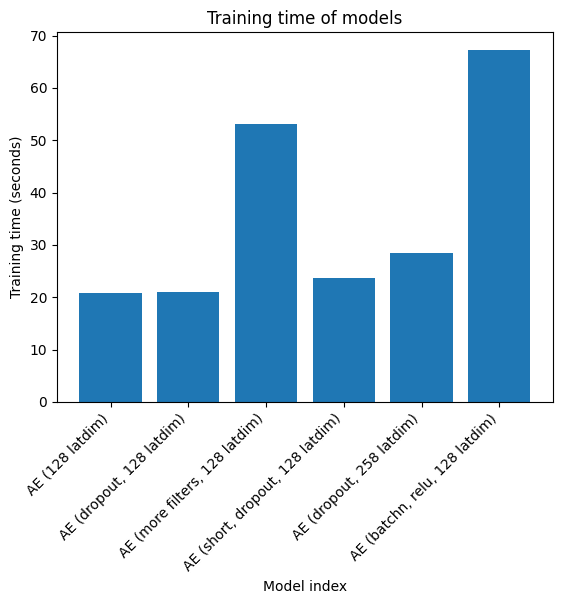

In [110]:
training_times = []
names = []
for m in models_list:
    if hasattr(m, 'training_time') and m.training_time is not None:
        training_times.append(m.training_time)
        names.append(m.name)

if training_times:
    plt.bar(names, training_times)
    plt.xlabel('Model index')
    plt.ylabel('Training time (seconds)')
    plt.title('Training time of models')
    plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees, align right
    plt.show()


In [9]:
def compare_models_loss_history(models, log10=True, title="Model's loss history"):
    """
    Compares the loss histories of multiple models by plotting their log-transformed losses.

    Parameters:
    - models: list of model objects, each containing a 'log.history["loss"]' attribute and a 'name'.

    Returns:
    - None: Displays a plot of the loss histories.
    """
    for i, model in enumerate(models):
        #color = decimal_to_rgb(i, len(models))
        #color = "#{:02x}{:02x}{:02x}".format(np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256))
        y = [model.history.history["loss"], np.log10(model.history.history["loss"])][log10]
        plt.plot(y, label=model.name) #, color=color
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss Log10") if log10 else plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

if models_list in locals(): # if the variable exists
    compare_models_loss_history(models_list, log10=True)

NameError: name 'models_list' is not defined

In [118]:
def plot_images(images, dimensions, fig_size=(10,8), titles=[], top_title="Image Gallery", cmap="viridis"):
    """
    Plots a grid of images with corresponding titles.

    Parameters:
    - images: list of numpy arrays, the images to be displayed.
    - dimensions: tuple of int (rows, cols), grid layout for images.
    - fig_size: tuple for the figure size, eg (10,8)
    - titles: list of str, the titles for each image.
    - top_title: str, optional, the title of the overall figure.

    Returns:
    - None: Displays the plot.
    """
    plt.figure(figsize=fig_size)
    plt.suptitle(top_title, fontsize=12, fontweight="bold", y=0.99)
    for i, img in enumerate(images):
        plt.subplot(dimensions[0], dimensions[1], i + 1)
        plt.imshow(img, cmap=cmap)
        if len(titles) == len(images):
            plt.title(titles[i], fontsize=10)
        plt.axis('off')
        plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


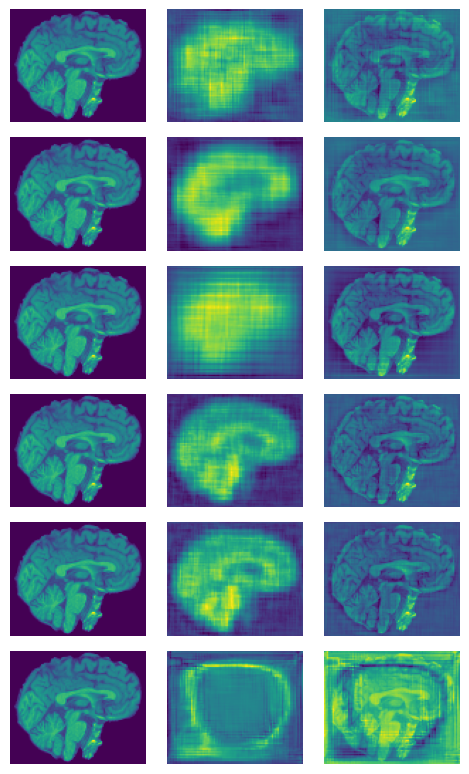

In [123]:
test_id = 1
images = []
for m in models_list:
    recon = m.decode(m.encode(test))
    input_image = np.rot90(test[test_id][40].reshape((96, 80)))
    recon_image = np.rot90(recon[test_id][40])
    images.append(input_image)
    images.append(recon_image)
    images.append(input_image - recon_image[:,:,0]) # recon shape is 3dim we need -> 2d

names = [] # 
plot_images(images, dimensions=(6,3), fig_size=(5, 8), titles=[], top_title="")